# Import libraries

In [2]:
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# What is A/B testing?

An A/B test is a controlled experiment used to determine whether a specific treatment causes a statistically significant change in a population metric of interest. Because studying the entire population is often impractical, a random sample is drawn and split randomly and independently into two groups: a control group and a treatment group. This random assignment helps neutralize the effects of confounding variables, allowing the experimenter to isolate and estimate the treatment's impact on the target metric.

# Designing an A/B test

Let's use a simplified example of a clinical experiment assessing the efficacy of a blood pressure medication to understand how to design an A/B test. The subsections below describe the components of the A/B test design. 

## Test objective

Determine whether the blood pressure medication reduces blood pressure more effectively than a placebo.

## Randomization unit

The randomization unit refers to the population entities that will be assigned randomly and independently to the control group vs. treatment group. For this example, the randomization unit will consist of adult patients aged 40-75 that have been diagnosed with Stage 1 or 2 hypertension. See below definitions of the two hypertension stages:

* Stage 1 hypertension: 130 mmHG $\leq$ Patient systolic blood pressure < 140 mmHG
* Stage 2 hypertension: Patient systolic blood pressure $\geq$ 140 mmHG

## Treatment

Patient administration of the blood pressure medication.

## Variants

* Control group: Patients receiving a placebo.
* Treatment group: Patients receiving the blood pressure medication.

## Metric of interest

The metric of interest refers to a quantitative measure of the test objective. For this example, the A/B test will compare the average patient systolic blood pressure between the variants at the end of the experiment. 

## Treatment effect with practical significance

The treatment effect with practical significance refers to the minimum difference in the metric of interest between the variants that is deemed meaningful. For this example, a minimum 5 mmHG reduction in systolic blood pressure resulting from the medication will be deemed clinically meaningful.

## Test Duration

The experiment will span 8 weeks to give sufficient time for the blood pressure medication to take effect. This will also enable the experimenters to detect any adverse side effects of the medication. 

## Overall evaluation criteria (OEC)

While A/B tests are primarily concerned with how the metric of interest changes as a result of applying the treatment, a comprehensive OEC that incorporates guardrail metrics provides a more nuanced approach to interpreting the treatment effect. For this example, experimenters will choose not to develop the medication further if 5% or more of the treatment group experiences severe side effects regardless of whether there is an observed drop in systolic blood pressure.

# Setting up the statistical hypothesis test

After establishing the high-level framework of the A/B test design, the next step is to set up the statistical hypothesis test that will be used in the A/B test.

## Hypotheses

* Null hypothesis: There is no difference in the average patient systolic blood pressure between the control group and the treatment group at the end of the experiment.
* Alternate hypothesis: The average patient systolic blood pressure of the treatment group is lower than that of the control group at the end of the experiment.

Notation definitions:
* $H_0:$ Null hypothesis
* $H_A:$ Alternate hypothesis
* $\mu_c:$ Average patient systolic blood pressure of the control group at the end of the experiment
* $\mu_t:$ Average patient systolic blood pressure of the treatment group at the end of the experiment

Notational description of the hypotheses:
* $H_0$: $\mu_c$ - $\mu_t$ $\leq 0$
* $H_A$: $\mu_c$ - $\mu_t$ $> 0$

## Type of statistical hypothesis test

For comparing the difference in the sample average patient systolic blood pressure between the control group and treatment group, a right-tailed two-sample t-test will be utilized since the population standard deviation of adult hypertension patients has to be estimated using the sample standard deviation. 

## Power of the test

Within the hypothesis framework, the power of the test describes the probability of correctly rejecting the null hypothesis when the alternate hypothesis is true. For this example, this is equivalent to correctly concluding that the drop in blood pressure resulting from the medication is statistically significant when the medication actually has efficacy. The power of the test will be set to 80% in accordance with standard protocol for A/B testing.

## Significance level

A corollary to the power of the test is the significance level, which describes the probability of incorrectly rejecting the null hypothesis when the null hypothesis is true (a.k.a. Type 1 error). For this example, this is equivalent to incorrectly concluding that the drop in blood pressure resulting from the medication is statistically significant when the medication actually has no efficacy. The significance level will be set to 5% in accordance with standard protocol for A/B testing.

## Sample size

The formula below is used to determine the number of samples that needs to be assigned to each variant in order for the right-tailed statistical hypothesis test to have the target power and significance level.
<br>
<br>

<span style="font-size:150%;">
$ n = \frac{2\sigma^2(Z_{\alpha}+Z_{\beta})^2}{\Delta^2} $
</span>
<br>
<br>

where:

$ \sigma = $ Population standard deviation of patients with hypertension

$ Z_{\alpha} = $ z-score corresponding to the significance level

$ Z_{\beta} = $ z-score corresponding to the power of the test

$ \Delta = $ Treatment effect with practical significance

See below the input variable values that will be used:

$ \sigma $ = 15 mmHG (obtained from historical study of hypertensive patients) 

$ Z_{\alpha} $ = 1.645

$ Z_{\beta} $ = 0.842

$ \Delta $ = 5 mmHG

Since there are two variants for this example, this number is doubled to obtain the aggregate sample size. 

$ 2n $ = Aggregate sample size

In [37]:
# Define function to calculate sample size/variant
def sample_size_calc(sigma, z_alpha, z_beta, delta):
    n = 2 * (sigma**2) * ((z_alpha + z_beta)**2) / (delta**2)
    return n

In [38]:
# Input variable values to calculate the sample size/variant
sigma = 15
z_alpha = st.norm.isf(q = 0.05, loc = 0, scale = 1)
z_beta = st.norm.isf(q = 0.2, loc = 0, scale = 1)
delta = 5

In [39]:
# Compute sample size/variant using function
sample_size_variant = sample_size_calc(sigma, z_alpha, z_beta, delta)
print(f'Sample size/variant = {sample_size_variant}')

Sample size/variant = 111.28603017635587


In [40]:
# Double and round up to the nearest integer to get the aggregate sample size
sample_size_total = int(round(sample_size_variant * 2, 0))
print(f'Aggregate sample size = {sample_size_total}')

Aggregate sample size = 223


# Obtaining the sample

A synthetic dataset was generated to simulate randomly sampling hypertension patients for a clinical trial. To replicate a real-life scenario, the dataset has several issues that need to be wrangled in preparation for conducting the statistical hypothesis test.

In [43]:
path_sample = 'baseline_sbp_data.csv'
df_sample = pd.read_csv(filepath_or_buffer = path_sample)

In [44]:
df_sample

,patient_id,age,sex,ethnicity,baseline_sbp
0,P1275,59,male,White,149
1,P1272,68,F,Other,158
2,P1197,69,F,Hispanic,155
3,P1164,47,F,White,153
4,P1095,59,F,Black,146
...,...,...,...,...,...
300,P1118,69,F,Hispanic,158
301,P1221,61,F,Black,147
302,P1031,50,FEMALE,NaN,145
303,P1121,69,male,White,154


# Data wrangling

A quick inspection of the dataframe shows that there are a total of 305 patient records, which exceed the minimum required sample size of 223. However, it is apparent that there may be data integrity issues (e.g., inconsistent labeling of sex). Let's begin wrangling the data.  

In [47]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patient_id    305 non-null    object
 1   age           305 non-null    int64 
 2   sex           300 non-null    object
 3   ethnicity     295 non-null    object
 4   baseline_sbp  305 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 12.0+ KB


Notes: 

* Values under column 'sex' are inconsistently labeled.
* Columns 'sex' and 'ethnicity' have null values.

In [49]:
# Check for duplicate patient_id
df_duplicates = df_sample[df_sample['patient_id'].duplicated(keep = False) == True].sort_values(by = 'patient_id')
df_duplicates

,patient_id,age,sex,ethnicity,baseline_sbp
189,P1038,63,FEMALE,Black,146
299,P1038,63,FEMALE,Black,146
218,P1089,58,F,White,138
228,P1089,58,F,White,138
62,P1138,56,male,Asian,160
107,P1138,56,male,Asian,160
2,P1197,69,F,Hispanic,155
52,P1197,69,F,Hispanic,155
17,P1240,71,M,White,143
158,P1240,71,M,White,143


Notes: 

* The code cell below outputs duplicate patient_id values.

In [51]:
duplicate_patients = df_duplicates['patient_id'].unique()
print(f'Duplicate patient_id: {duplicate_patients}')

Duplicate patient_id: ['P1038' 'P1089' 'P1138' 'P1197' 'P1240']


In [52]:
# Check the format and progression of values under column 'patient_id'
df_sample['patient_id'].sort_values()

102    P1000
27     P1001
270    P1002
195    P1003
254    P1004
       ...  
294    P1295
63     P1296
11     P1297
160    P1298
104    P1299
Name: patient_id, Length: 305, dtype: object

In [53]:
# Check to make sure that all patient_id values follow the format "P####"
df_sample['patient_id'][df_sample['patient_id'].str.fullmatch(r'P\d{4}') == False]

Series([], Name: patient_id, dtype: object)

Notes:

* There are no patient_id values that break the format standard 'P####'.

In [55]:
df_sample.describe()

,age,baseline_sbp
count,305.000000,305.000000
mean,58.577049,150.904918
std,8.274970,13.794097
min,40.000000,100.000000
25%,53.000000,143.000000
50%,59.000000,151.000000
75%,65.000000,159.000000
max,74.000000,196.000000


Recall the following definitions for Stage 1 and 2 hypertension:

* Stage 1 hypertension: 130 mmHG $\leq$ Patient systolic blood pressure < 140 mmHG
* Stage 2 hypertension: Patient systolic blood pressure $\geq$ 140 mmHG

Notes:

* The descriptive statistics shown above indicate that the minimum and maximum baseline systolic blood pressures in the data are 100 mmHG and 196 mmHG, respectively. The former is problematic because there's no indication of hypertension whereas the latter is likely an erroneous measurement since anyone with a systolic blood pressure above 180 mmHG would be in a medical emergency.

In [57]:
# Isolate non-hypertensive records
df_not_hyper = df_sample[(df_sample['baseline_sbp'] < 130) | (df_sample['baseline_sbp'] > 180)]
df_not_hyper

,patient_id,age,sex,ethnicity,baseline_sbp
7,P1026,51,M,Black,129
10,P1215,52,F,White,126
20,P1132,48,female,Hispanic,116
21,P1156,63,F,White,109
28,P1090,48,M,White,195
29,P1279,66,F,White,192
42,P1181,48,F,Black,128
47,P1233,59,F,White,196
68,P1067,66,male,White,129
85,P1165,67,F,Hispanic,129


In [58]:
# Count the number of non-hypertensive records
print(f'Number of records that are not hypertension: {len(df_not_hyper)}')

Number of records that are not hypertension: 26


In [59]:
# Retrieve unique values under column 'sex'
sex_labels = df_sample['sex'].unique()
print(f'Unique values under column "sex": {sex_labels}')

Unique values under column "sex": ['male' 'F' 'M' nan 'female' 'FEMALE' 'm']


In [60]:
# Inspect patient records with null values under column 'sex'
df_sample[df_sample['sex'].isna()]

,patient_id,age,sex,ethnicity,baseline_sbp
12,P1169,61,NaN,White,148
132,P1236,54,NaN,White,161
197,P1037,47,NaN,White,160
219,P1180,55,NaN,Hispanic,182
287,P1202,50,NaN,White,154


Notes: 

* The 'sex' column has the following issues:
    * There are different variations of labels.
    * There are null values.

In [62]:
# Retrieve unique values under column 'ethnicity'
ethnicity_labels = df_sample['ethnicity'].unique()
print(f'Unique values under column "ethnicity": {ethnicity_labels}')

Unique values under column "ethnicity": ['White' 'Other' 'Hispanic' 'Black' nan 'Asian']


In [63]:
df_sample[df_sample['ethnicity'].isna()]

,patient_id,age,sex,ethnicity,baseline_sbp
51,P1141,53,FEMALE,NaN,146
56,P1047,59,F,NaN,144
91,P1030,61,M,NaN,162
125,P1160,56,F,NaN,151
139,P1231,59,male,NaN,192
175,P1158,52,F,NaN,159
182,P1206,48,M,NaN,148
205,P1217,65,male,NaN,150
250,P1103,59,F,NaN,160
302,P1031,50,FEMALE,NaN,145


Notes:

* Column 'ethnicity' has null values.

## Action items

Based on the observations from inspecting the raw data, let's make the following revisions:

* Remove duplicate patient_id records.
* Remove non-hypertensive records.
* Apply consistent formatting for values under column 'sex' as "Male" or "Female".
* Consistently format null values under columns 'sex' and 'ethnicity' as "Unknown".

In [67]:
# Remove duplicate patient_id records
df_sample.drop_duplicates(inplace = True)

# Reset numeric index
df_sample.reset_index(drop = True, inplace = True)

In [68]:
# Confirm that each duplicate patient_id now only has one record
df_sample[df_sample['patient_id'].isin(duplicate_patients) == True].sort_values(by = 'patient_id')

,patient_id,age,sex,ethnicity,baseline_sbp
186,P1038,63,FEMALE,Black,146
215,P1089,58,F,White,138
61,P1138,56,male,Asian,160
2,P1197,69,F,Hispanic,155
17,P1240,71,M,White,143


In [69]:
# Remove non-hypertensive records from the original data
df_sample = df_sample[(df_sample['baseline_sbp'] > 130) & (df_sample['baseline_sbp'] < 180)]

# Reset numeric index
df_sample.reset_index(drop = True, inplace = True)

In [70]:
# Confirm that non-hypertensive records have been removed
df_sample['baseline_sbp'].describe()

count    271.000000
mean     151.221402
std        9.705042
min      131.000000
25%      144.000000
50%      151.000000
75%      158.000000
max      174.000000
Name: baseline_sbp, dtype: float64

In [71]:
# Dictionary to map different variations under column 'sex' to a consistent label
sex_map = {'male': 'Male', 
           'm': 'Male', 
           'M': 'Male',
           'female': 'Female', 
           'F': 'Female', 
           'FEMALE': 'Female'
          }

In [72]:
# Apply map
df_sample.loc[:, 'sex'] = df_sample['sex'].map(sex_map)

In [73]:
# Confirm consistent labeling under column 'sex'
df_sample['sex'].unique()

array(['Male', 'Female', nan], dtype=object)

In [74]:
# Dictionary to fill null values by column name
null_map = {'sex': 'Unknown',
            'ethnicity': 'Unknown'
           }

In [75]:
# Fill null values under columns 'sex' and 'ethnicity' using dictionary
df_sample.fillna(value = null_map, inplace = True)

C:\Users\eslee\AppData\Local\Temp\ipykernel_5236\3860027575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample.fillna(value = null_map, inplace = True)


In [76]:
# Check that null values under column 'sex' are labeled as "Unknown"
df_sample['sex'].unique()

array(['Male', 'Female', 'Unknown'], dtype=object)

In [77]:
# Check that null values under column 'ethnicity' are labeled as "Unknown"
df_sample['ethnicity'].unique()

array(['White', 'Other', 'Hispanic', 'Black', 'Unknown', 'Asian'],
      dtype=object)

In [78]:
# Show clean dataset
df_sample

,patient_id,age,sex,ethnicity,baseline_sbp
0,P1275,59,Male,White,149
1,P1272,68,Female,Other,158
2,P1197,69,Female,Hispanic,155
3,P1164,47,Female,White,153
4,P1095,59,Female,Black,146
...,...,...,...,...,...
266,P1118,69,Female,Hispanic,158
267,P1221,61,Female,Black,147
268,P1031,50,Female,Unknown,145
269,P1121,69,Male,White,154


# Exploratory data analysis

With initial data wrangling completed, let's conduct univariate and multivariate exploratory data analysis to study the clean dataset more closely.

## Univariate analysis

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


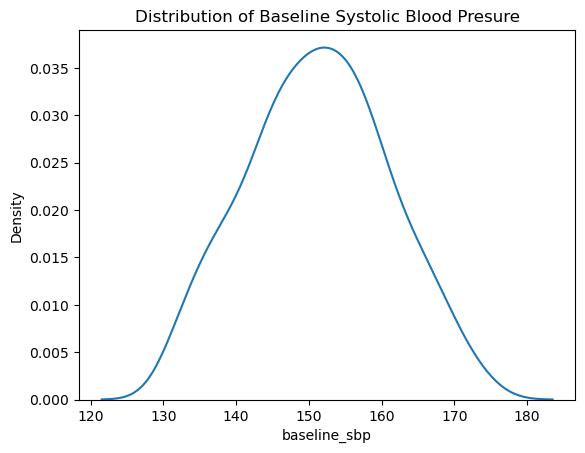

In [82]:
# Distribution of baseline_sbp
baseline_sbp_kde = sns.kdeplot(data = df_sample['baseline_sbp'])
baseline_sbp_kde.set_title('Distribution of Baseline Systolic Blood Presure')
baseline_sbp_kde;

In [83]:
df_sample['baseline_sbp'].describe()

count    271.000000
mean     151.221402
std        9.705042
min      131.000000
25%      144.000000
50%      151.000000
75%      158.000000
max      174.000000
Name: baseline_sbp, dtype: float64

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


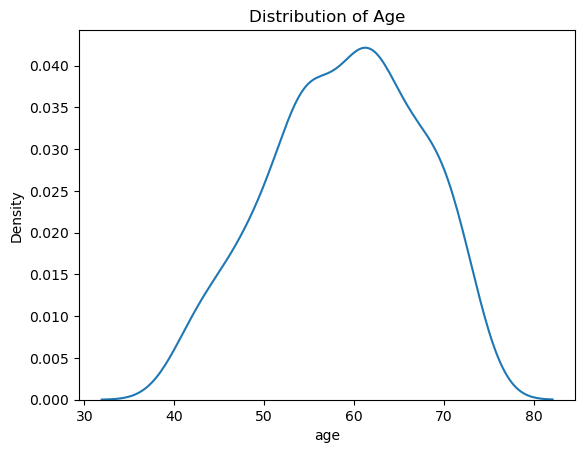

In [84]:
# Distribution of age
age_kde = sns.kdeplot(data = df_sample['age'])
age_kde.set_title('Distribution of Age')
age_kde;

In [85]:
df_sample['age'].describe()

count    271.000000
mean      58.907749
std        8.256242
min       40.000000
25%       53.000000
50%       59.000000
75%       65.000000
max       74.000000
Name: age, dtype: float64

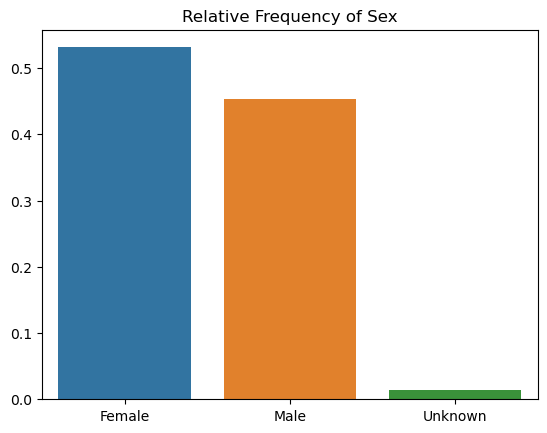

In [86]:
# Distribution of sex
sex_dist = df_sample['sex'].value_counts(normalize = True).reset_index()
sex_bar = sns.barplot(data = sex_dist,
                      x = 'sex',
                      y = 'proportion', 
                     )
sex_bar.set_title('Relative Frequency of Sex')
sex_bar.set_xlabel('')
sex_bar.set_ylabel('')

sex_bar;

In [87]:
df_sample['sex'].value_counts(normalize = True)

sex
Female     0.531365
Male       0.453875
Unknown    0.014760
Name: proportion, dtype: float64

In [88]:
df_sample['sex'].value_counts()

sex
Female     144
Male       123
Unknown      4
Name: count, dtype: int64

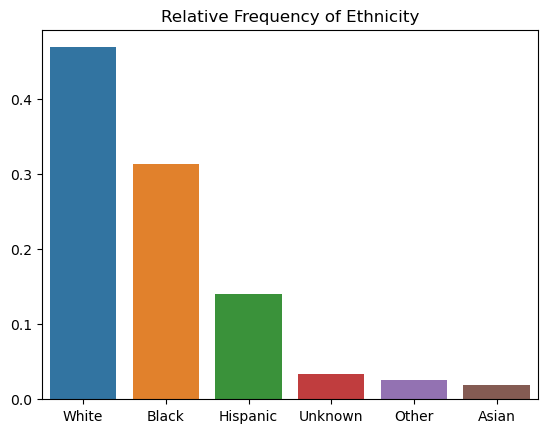

In [89]:
# Distribution of ethnicity
ethnicity_dist = df_sample['ethnicity'].value_counts(normalize = True).reset_index()
ethnicity_bar = sns.barplot(data = ethnicity_dist,
                      x = 'ethnicity',
                      y = 'proportion', 
                     )
ethnicity_bar.set_title('Relative Frequency of Ethnicity')
ethnicity_bar.set_xlabel('')
ethnicity_bar.set_ylabel('')

ethnicity_bar;

In [90]:
df_sample['ethnicity'].value_counts(normalize = True)

ethnicity
White       0.468635
Black       0.313653
Hispanic    0.140221
Unknown     0.033210
Other       0.025830
Asian       0.018450
Name: proportion, dtype: float64

In [91]:
df_sample['ethnicity'].value_counts()

ethnicity
White       127
Black        85
Hispanic     38
Unknown       9
Other         7
Asian         5
Name: count, dtype: int64

Notes:

* Baseline systolic blood pressur is approximately normally distributed with a mean around 151 mmHG and a standard deviation around 10 mmHG.
* Age is approximately normally distributed with a mean around 59 years and a standard deviation around 8 years.
* Sex is close to evenly distributed with about 53% females and 45% males. A small remaining percentage of records have unknown sex.
* Ethnicity is imbalanced. In particular, 'Asian' and 'Other' together only make up a little over 4% of the overall sample. About 3% of the records
  have unknown ethnicity.

In [93]:
df_unknown = df_sample[(df_sample['sex'] == 'Unknown') | (df_sample['ethnicity'] == 'Unknown')]
df_unknown

,patient_id,age,sex,ethnicity,baseline_sbp
9,P1169,61,Unknown,White,148
42,P1141,53,Female,Unknown,146
46,P1047,59,Female,Unknown,144
77,P1030,61,Male,Unknown,162
107,P1160,56,Female,Unknown,151
114,P1236,54,Unknown,White,161
150,P1158,52,Female,Unknown,159
157,P1206,48,Male,Unknown,148
170,P1037,47,Unknown,White,160
178,P1217,65,Male,Unknown,150


C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


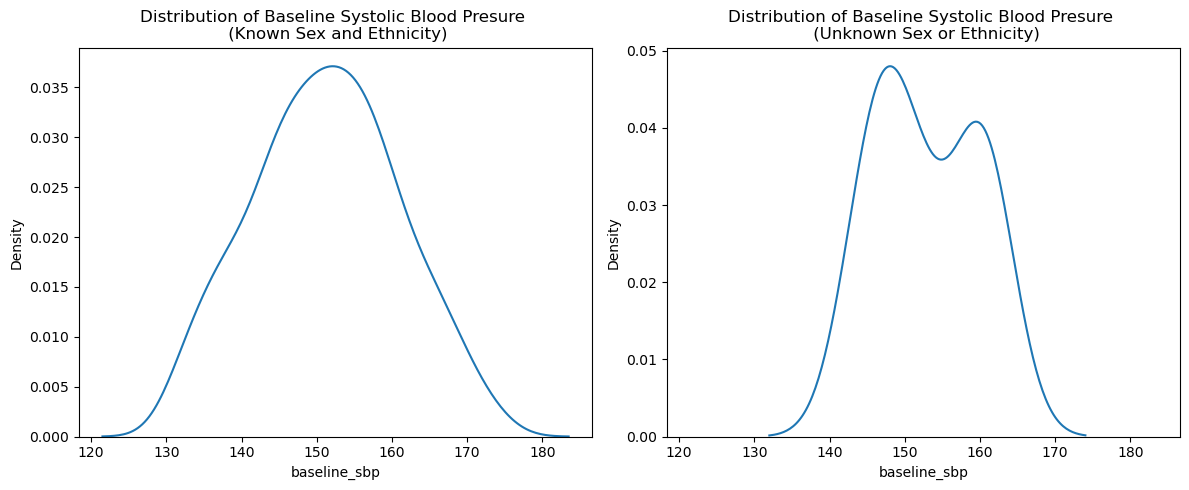

In [94]:
# Distribution of baseline_sbp for unknown sex or ethnicity compared

## Instantiate fig, ax objects
fig_baseline_sbp, axes_baseline_sbp = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), sharex = True)

## Plot distributions of baseline_sbp
sns.kdeplot(data = df_sample.dropna(subset = ['sex', 'ethnicity'])['baseline_sbp'], ax = axes_baseline_sbp[0])
sns.kdeplot(data = df_unknown['baseline_sbp'], ax = axes_baseline_sbp[1])

## Format plots
axes_baseline_sbp[0].set_title('Distribution of Baseline Systolic Blood Presure \n (Known Sex and Ethnicity)')
axes_baseline_sbp[1].set_title('Distribution of Baseline Systolic Blood Presure \n (Unknown Sex or Ethnicity)')
plt.tight_layout()

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


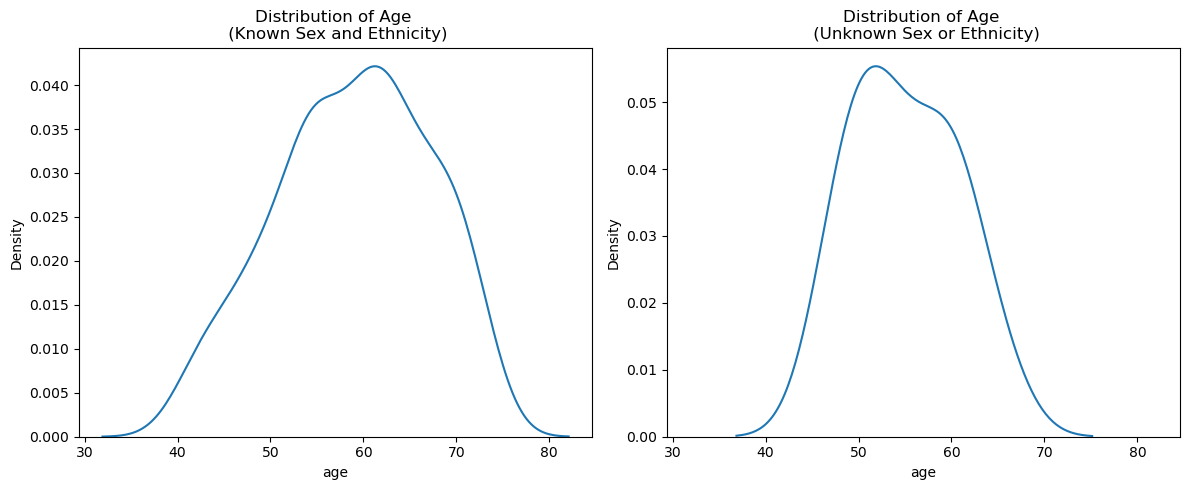

In [95]:
# Distribution of age for unknown sex or ethnicity compared

## Instantiate figure and axes objects
fig_age, axes_age = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), sharex = True)

## Plot distributions of age
sns.kdeplot(data = df_sample.dropna(subset = ['sex', 'ethnicity'])['age'], ax = axes_age[0])
sns.kdeplot(data = df_unknown['age'], ax = axes_age[1])

## Format plots
axes_age[0].set_title('Distribution of Age \n (Known Sex and Ethnicity)')
axes_age[1].set_title('Distribution of Age \n (Unknown Sex or Ethnicity)')
plt.tight_layout()

In [96]:
pct_unknown = len(df_unknown) / len(df_sample)
print(f'% of records with unknown values: {pct_unknown * 100:.1f}%')

% of records with unknown values: 4.8%


Notes:

* Patient records with an unknown value in either the 'sex' or 'ethnicity' column make up less than 5% of the overall dataset.
* The distributions of baseline systolic blood pressure and age do not differ significantly between the records with unknown values and the remaining
  records with known values.

## Action items

Let's drop the 13 patient records with unknown values under columns 'sex' and 'ethnicity' since:
* There's no distinct pattern either age or baseline systolic blood pressure
* They make up a small percentage of the overall dataset
* Dropping unknown values can help set up stratified analysis by demographic later if needed.

In [100]:
df_sample = df_sample[(df_sample['sex'] != 'Unknown') & (df_sample['ethnicity'] != 'Unknown')]
df_sample

,patient_id,age,sex,ethnicity,baseline_sbp
0,P1275,59,Male,White,149
1,P1272,68,Female,Other,158
2,P1197,69,Female,Hispanic,155
3,P1164,47,Female,White,153
4,P1095,59,Female,Black,146
...,...,...,...,...,...
265,P1267,64,Male,White,137
266,P1118,69,Female,Hispanic,158
267,P1221,61,Female,Black,147
269,P1121,69,Male,White,154


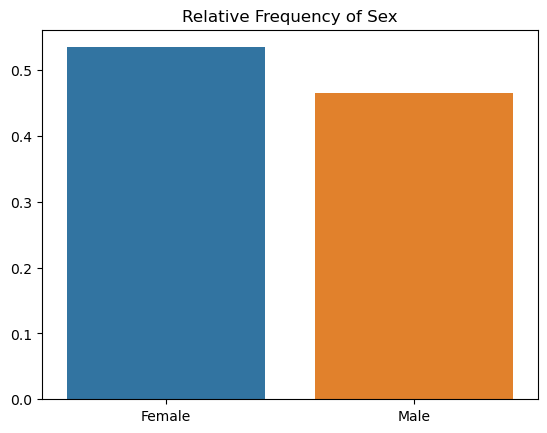

In [101]:
# Distribution of sex
sex_dist = df_sample['sex'].value_counts(normalize = True).reset_index()
sex_bar = sns.barplot(data = sex_dist,
                      x = 'sex',
                      y = 'proportion', 
                     )

sex_bar.set_title('Relative Frequency of Sex')
sex_bar.set_xlabel('')
sex_bar.set_ylabel('')

sex_bar;

In [102]:
df_sample['sex'].value_counts(normalize = True)

sex
Female    0.534884
Male      0.465116
Name: proportion, dtype: float64

In [103]:
df_sample['sex'].value_counts()

sex
Female    138
Male      120
Name: count, dtype: int64

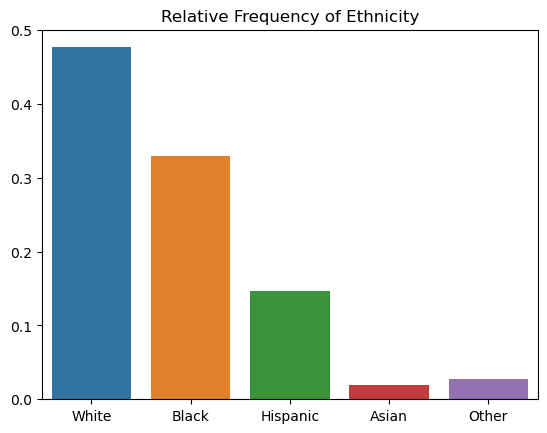

In [104]:
# Distribution of ethnicity
ethnicities = ['White', 'Black', 'Hispanic', 'Asian', 'Other']
ethnicity_dist = df_sample['ethnicity'].value_counts(normalize = True).reset_index()
ethnicity_bar = sns.barplot(data = ethnicity_dist,
                            x = 'ethnicity',
                            y = 'proportion',
                            order = ethnicities
                           )

ethnicity_bar.set_title('Relative Frequency of Ethnicity')
ethnicity_bar.set_xlabel('')
ethnicity_bar.set_ylabel('')

ethnicity_bar;

In [105]:
df_sample['ethnicity'].value_counts(normalize = True)

ethnicity
White       0.476744
Black       0.329457
Hispanic    0.147287
Other       0.027132
Asian       0.019380
Name: proportion, dtype: float64

In [106]:
df_sample['ethnicity'].value_counts()

ethnicity
White       123
Black        85
Hispanic     38
Other         7
Asian         5
Name: count, dtype: int64

Notes:

* Given the imbalance in the distribution of ethnicity, consider stratified randomization during variant assignment to retain a similar
  ethncity distribution.

## Multivariate analysis

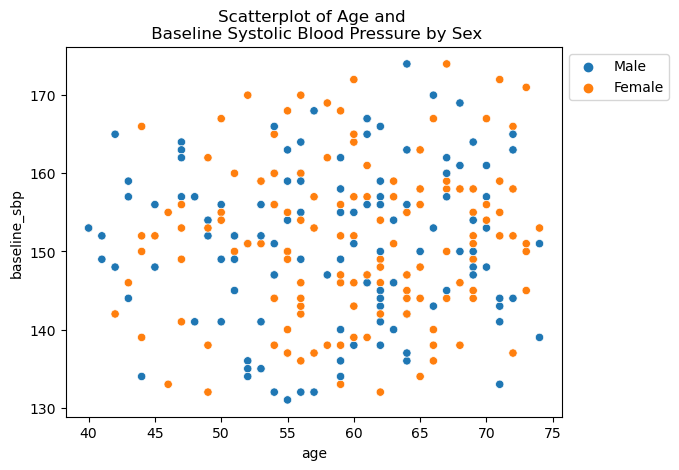

In [109]:
# Scatterplot between age and baseline_sbp differentiated by sex

## Instantiate figure and axes objects
fig_scatter_1, axes_scatter_1 = plt.subplots()

## Create scatterplot
sns.scatterplot(data = df_sample, x = 'age', y = 'baseline_sbp', hue = 'sex', ax = axes_scatter_1) ### Color code by sex

## Format plot
axes_scatter_1.set_title('Scatterplot of Age and \n Baseline Systolic Blood Pressure by Sex')
axes_scatter_1.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

In [110]:
# Overall correlation between age and baseline_sbp 
corr_matrix_age = df_sample.corr(numeric_only = True)
corr_matrix_age

,age,baseline_sbp
age,1.000000,0.052768
baseline_sbp,0.052768,1.000000


In [111]:
# Correlation between age and baseline_sbp for male
corr_matrix_age_male = df_sample[df_sample['sex'] == 'Male'].corr(numeric_only = True)
corr_matrix_age_male

,age,baseline_sbp
age,1.000000,0.013839
baseline_sbp,0.013839,1.000000


In [112]:
# Correlation between age and baseline_sbp for female
corr_matrix_age_female = df_sample[df_sample['sex'] == 'Female'].corr(numeric_only = True)
corr_matrix_age_female

,age,baseline_sbp
age,1.000000,0.088096
baseline_sbp,0.088096,1.000000


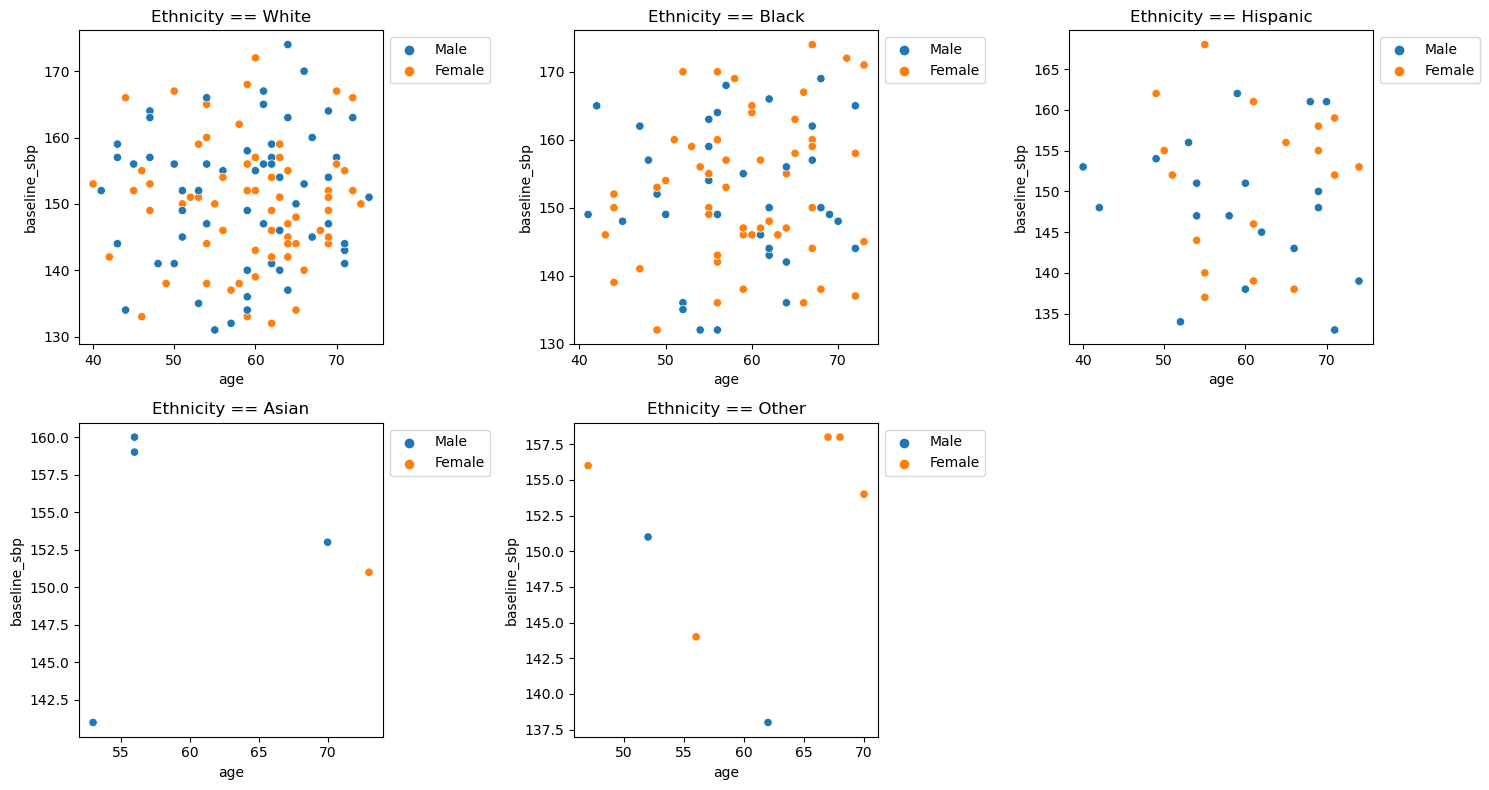

In [113]:
# Scatterplots between age and baseline_sbp differentiated by ethnicity

## Instantiate figure and axes objects
fig_scatter_2, axes_scatter_2 = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))

## Create scatterplots
sns.scatterplot(data = df_sample[df_sample['ethnicity'] == 'White'], 
                x = 'age', 
                y = 'baseline_sbp', 
                hue = 'sex',
                hue_order = ['Male', 'Female'],
                ax = axes_scatter_2[0][0]) ### Ethnicity: White

sns.scatterplot(data = df_sample[df_sample['ethnicity'] == 'Black'], 
                x = 'age', 
                y = 'baseline_sbp', 
                hue = 'sex',
                hue_order = ['Male', 'Female'],
                ax = axes_scatter_2[0][1]) ### Ethnicity: Black

sns.scatterplot(data = df_sample[df_sample['ethnicity'] == 'Hispanic'], 
                x = 'age', 
                y = 'baseline_sbp',
                hue = 'sex',
                hue_order = ['Male', 'Female'],
                ax = axes_scatter_2[0][2]) ### Ethnicity: Hispanic

sns.scatterplot(data = df_sample[df_sample['ethnicity'] == 'Asian'], 
                x = 'age', 
                y = 'baseline_sbp',  
                hue = 'sex',
                hue_order = ['Male', 'Female'],
                ax = axes_scatter_2[1][0]) ### Ethnicity: Asian

sns.scatterplot(data = df_sample[df_sample['ethnicity'] == 'Other'], 
                x = 'age', 
                y = 'baseline_sbp',  
                hue = 'sex',
                hue_order = ['Male', 'Female'],
                ax = axes_scatter_2[1][1]) ### Ethnicity: Other

## Format plot
axes_scatter_2[0][0].set_title('Ethnicity == White')
axes_scatter_2[0][1].set_title('Ethnicity == Black')
axes_scatter_2[0][2].set_title('Ethnicity == Hispanic')
axes_scatter_2[1][0].set_title('Ethnicity == Asian')
axes_scatter_2[1][1].set_title('Ethnicity == Other')

axes_scatter_2[0][0].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
axes_scatter_2[0][1].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
axes_scatter_2[0][2].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
axes_scatter_2[1][0].legend(loc = 'upper left', bbox_to_anchor = (1, 1))
axes_scatter_2[1][1].legend(loc = 'upper left', bbox_to_anchor = (1, 1))

axes_scatter_2[1][2].set_visible(False)

plt.tight_layout()

In [114]:
# Correlation between age and baseline_sbp by ethnicity
for i in ethnicities:
    print(f'Correlation Matrix ({i}):')
    print()
    print(df_sample[df_sample['ethnicity'] == i].corr(numeric_only = True))
    print()

Correlation Matrix (White):

                   age  baseline_sbp
age           1.000000      0.020593
baseline_sbp  0.020593      1.000000

Correlation Matrix (Black):

                   age  baseline_sbp
age           1.000000      0.127772
baseline_sbp  0.127772      1.000000

Correlation Matrix (Hispanic):

                   age  baseline_sbp
age           1.000000     -0.017017
baseline_sbp -0.017017      1.000000

Correlation Matrix (Asian):

                   age  baseline_sbp
age           1.000000      0.027126
baseline_sbp  0.027126      1.000000

Correlation Matrix (Other):

                   age  baseline_sbp
age           1.000000      0.177119
baseline_sbp  0.177119      1.000000



In [115]:
# Correlation between age and baseline_sbp by ethnicity and male
for i in ethnicities:
    print(f'Correlation Matrix ({i}, Male):')
    print()
    print(df_sample[(df_sample['ethnicity'] == i) & (df_sample['sex'] == 'Male')].corr(numeric_only = True))
    print()

Correlation Matrix (White, Male):

                   age  baseline_sbp
age           1.000000      0.061149
baseline_sbp  0.061149      1.000000

Correlation Matrix (Black, Male):

                   age  baseline_sbp
age           1.000000      0.031513
baseline_sbp  0.031513      1.000000

Correlation Matrix (Hispanic, Male):

                   age  baseline_sbp
age           1.000000     -0.151361
baseline_sbp -0.151361      1.000000

Correlation Matrix (Asian, Male):

                   age  baseline_sbp
age           1.000000      0.166304
baseline_sbp  0.166304      1.000000

Correlation Matrix (Other, Male):

              age  baseline_sbp
age           1.0          -1.0
baseline_sbp -1.0           1.0



In [116]:
# Correlation between age and baseline_sbp by ethnicity and female
for i in ethnicities:
    print(f'Correlation Matrix ({i}, Female):')
    print()
    print(df_sample[(df_sample['ethnicity'] == i) & (df_sample['sex'] == 'Female')].corr(numeric_only = True))
    print()

Correlation Matrix (White, Female):

                   age  baseline_sbp
age           1.000000     -0.015867
baseline_sbp -0.015867      1.000000

Correlation Matrix (Black, Female):

                   age  baseline_sbp
age           1.000000      0.192469
baseline_sbp  0.192469      1.000000

Correlation Matrix (Hispanic, Female):

                   age  baseline_sbp
age           1.000000      0.115467
baseline_sbp  0.115467      1.000000

Correlation Matrix (Asian, Female):

              age  baseline_sbp
age           NaN           NaN
baseline_sbp  NaN           NaN

Correlation Matrix (Other, Female):

                  age  baseline_sbp
age           1.00000       0.32331
baseline_sbp  0.32331       1.00000



Notes:

* The correlation between age and baseline systolic blood pressure is weak in aggregate, across the sexes, and across all ethnicities even after
  accounting for differences in sex.
* The sample size is too small for ethnicities 'Asian' and 'Other' to reliably calculate their correlation coefficients. 

In [118]:
# Set up bins for age groups to add as a column to the dataframe
bins_age = [39, 49, 59, 69, 79]
bins_age_labels = ['40s', '50s', '60s', '70s']

# Create new column 'age_group' with bin values
df_sample['age_group'] = pd.cut(x = df_sample.loc[:, 'age'], labels = bins_age_labels, bins = bins_age, right = True)

C:\Users\eslee\AppData\Local\Temp\ipykernel_5236\4062083730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['age_group'] = pd.cut(x = df_sample.loc[:, 'age'], labels = bins_age_labels, bins = bins_age, right = True)


In [119]:
column_order = ['patient_id', 'age', 'age_group', 'sex', 'ethnicity', 'baseline_sbp']
df_sample = df_sample.reindex(columns = column_order)

In [120]:
df_sample

,patient_id,age,age_group,sex,ethnicity,baseline_sbp
0,P1275,59,50s,Male,White,149
1,P1272,68,60s,Female,Other,158
2,P1197,69,60s,Female,Hispanic,155
3,P1164,47,40s,Female,White,153
4,P1095,59,50s,Female,Black,146
...,...,...,...,...,...,...
265,P1267,64,60s,Male,White,137
266,P1118,69,60s,Female,Hispanic,158
267,P1221,61,60s,Female,Black,147
269,P1121,69,60s,Male,White,154


In [121]:
# Frequency distribution of age_group
age_group_freq = df_sample['age_group'].value_counts().reindex(index = bins_age_labels).reset_index()
age_group_freq

,age_group,count
0,40s,37
1,50s,89
2,60s,103
3,70s,29


In [122]:
# Relative frequency distribution of age_group
age_group_rfreq = df_sample['age_group'].value_counts(normalize = True).reindex(index = bins_age_labels).reset_index()
age_group_rfreq

,age_group,proportion
0,40s,0.143411
1,50s,0.344961
2,60s,0.399225
3,70s,0.112403


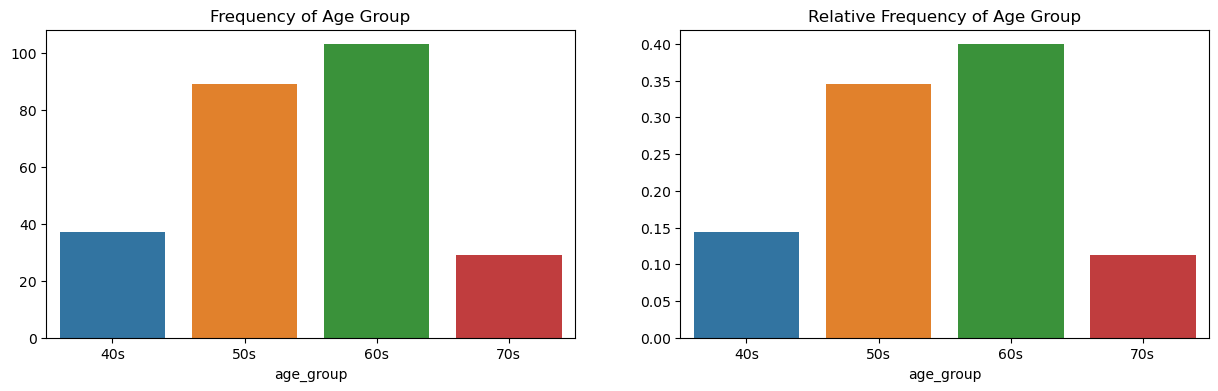

In [123]:
# Distribution of age_group

## Instantiate figure and axes objects
fig_age_group, axes_age_group = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

## Create bar plots
sns.barplot(data = age_group_freq, x = 'age_group', y = 'count', ax = axes_age_group[0])
sns.barplot(data = age_group_rfreq, x = 'age_group', y = 'proportion', ax = axes_age_group[1])

## Format plot
axes_age_group[0].set_title('Frequency of Age Group')
axes_age_group[1].set_title('Relative Frequency of Age Group')

axes_age_group[0].set_ylabel('')
axes_age_group[1].set_ylabel('')

fig_age_group.subplots_adjust(wspace = 0.2)

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


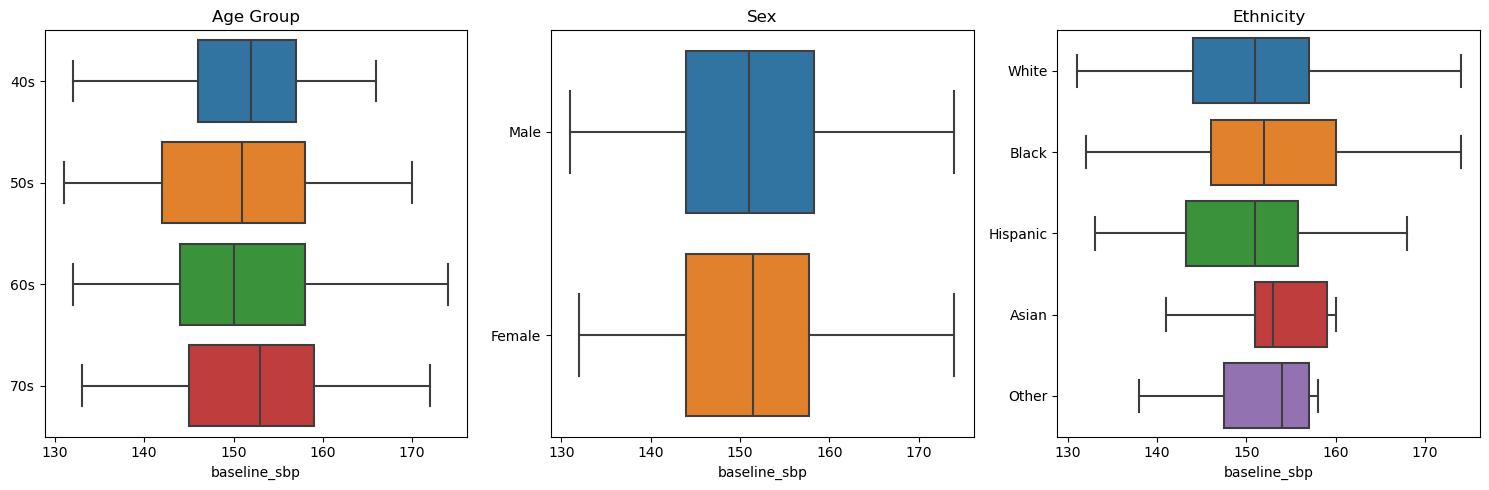

In [124]:
# Boxplots between categorical independent variables and baseline_sbp

## Instantiate figure and axes objects
fig_box_1, axes_box_1 = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))

## Create scatterplots
sns.boxplot(data = df_sample, x = 'baseline_sbp', y = 'age_group', ax = axes_box_1[0])
sns.boxplot(data = df_sample, x = 'baseline_sbp', y = 'sex', ax = axes_box_1[1])
sns.boxplot(data = df_sample, x = 'baseline_sbp', y = 'ethnicity', order = ethnicities, ax = axes_box_1[2])


## Format plot
axes_box_1[0].set_title('Age Group')
axes_box_1[1].set_title('Sex')
axes_box_1[2].set_title('Ethnicity')

axes_box_1[0].set_ylabel('')
axes_box_1[1].set_ylabel('')
axes_box_1[2].set_ylabel('')

plt.tight_layout()

Notes: 

* The differences in the distribution of bseline systolic blood pressure across age group, sex, and ethnicity do not appear significant.
* There are too few samples in ethnicities 'Asian' and 'Other' to draw meaningful inferences about their baseline systolic blood pressure distributions.
* A more granular stratified exploratory data analysis (e.g., distribution of baseline systolic blood pressure by age group and ethnicity) will not be
  conducted since each strata will have few samples assigned to it. 

# Random and independent assignment to variants

Although there does not appear to be a significant difference in the distribution of baseline systolic blood pressure by ethnicity, stratified randomization by ethnicity will be used for variant assignment to account for the imbalance in ethnicity and to keep the distribution of ethnicity consistent between the control and treatment groups. This will also help if ethnicity is later found to be a confounding variable that affects how patients react to the medication.

In [128]:
# STratified randomization for variant assignment

## Seed for reproducibility
np.random.seed(42)  

df_variants = df_sample.copy()
df_variants['variant'] = '' 

for ethnicity in ethnicities:
    idx = df_variants[df_variants['ethnicity'] == ethnicity].index
    n = len(idx)
    assignments = np.array(['Control'] * (n // 2) + ['Treatment'] * (n - n // 2))
    np.random.shuffle(assignments)
    df_variants.loc[idx, 'variant'] = assignments

In [129]:
df_variants

,patient_id,age,age_group,sex,ethnicity,baseline_sbp,variant
0,P1275,59,50s,Male,White,149,Control
1,P1272,68,60s,Female,Other,158,Treatment
2,P1197,69,60s,Female,Hispanic,155,Treatment
3,P1164,47,40s,Female,White,153,Control
4,P1095,59,50s,Female,Black,146,Treatment
...,...,...,...,...,...,...,...
265,P1267,64,60s,Male,White,137,Control
266,P1118,69,60s,Female,Hispanic,158,Control
267,P1221,61,60s,Female,Black,147,Control
269,P1121,69,60s,Male,White,154,Treatment


## Inspection

Let's conduct univariate and multivariate exploratory data analysis on each variant to confirm whether the original aggregate data characteristics have been retained.

In [132]:
# Confirm values under new column 'variant'
df_variants['variant'].unique()

array(['Control', 'Treatment'], dtype=object)

In [133]:
# Frequency distribution of variants
variant_freq = df_variants['variant'].value_counts().sort_values().reset_index()
variant_freq

,variant,count
0,Control,127
1,Treatment,131


In [134]:
# Relative frequency distribution of variants
variant_rfreq = df_variants['variant'].value_counts(normalize = True).sort_values().reset_index()
variant_rfreq

,variant,proportion
0,Control,0.492248
1,Treatment,0.507752


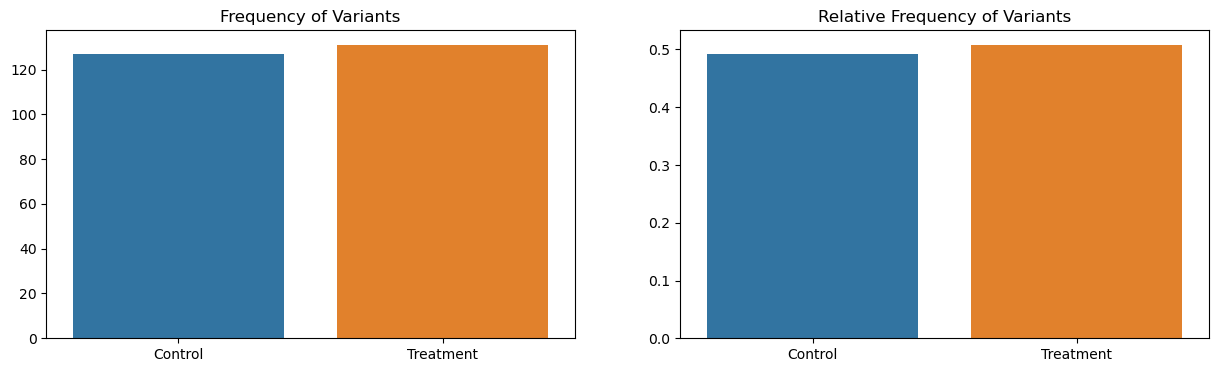

In [135]:
# Distribution of variants

## Instantiate figure and axes objects
fig_variant, axes_variant = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))

## Plot frequency and relative frequency
sns.barplot(data = variant_freq, x = 'variant', y = 'count', ax = axes_variant[0])
sns.barplot(data = variant_rfreq, x = 'variant', y = 'proportion', ax = axes_variant[1])

## Format plot
axes_variant[0].set_title('Frequency of Variants')
axes_variant[1].set_title('Relative Frequency of Variants')

axes_variant[0].set_xlabel('')
axes_variant[1].set_xlabel('')
axes_variant[0].set_ylabel('')
axes_variant[1].set_ylabel('')

fig_variant.subplots_adjust(wspace = 0.2)

Notes:

* Minimum sample size/variant of 111 met.

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

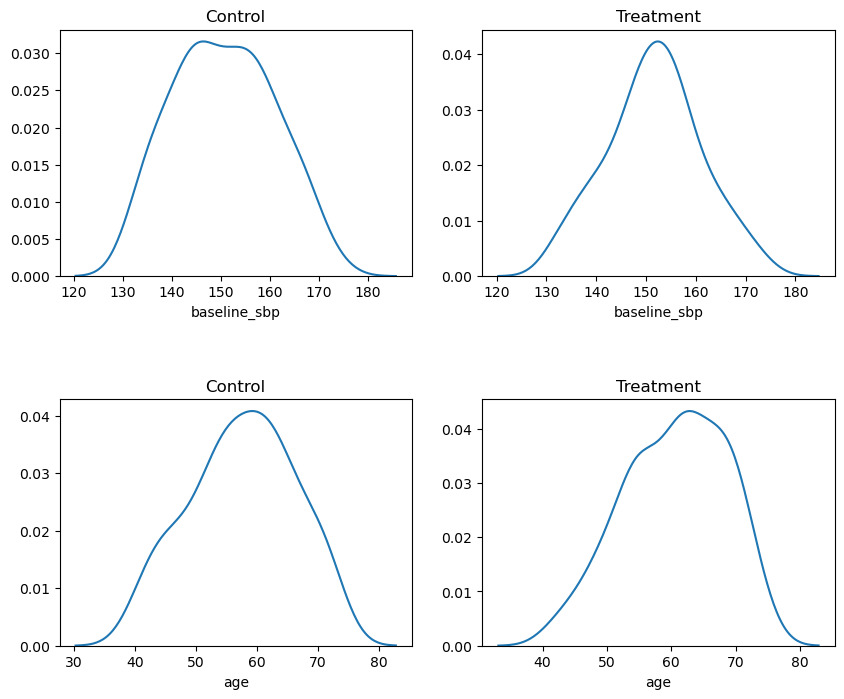

In [137]:
# Distribution of baseline_sbp by variant

## Instantiate figure and axes objects
fig_variant_kde, axes_variant_kde = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))

## Plot frequency and relative frequency
sns.kdeplot(data = df_variants['baseline_sbp'][df_variants['variant'] == 'Control'], ax = axes_variant_kde[0][0])
sns.kdeplot(data = df_variants['baseline_sbp'][df_variants['variant'] == 'Treatment'], ax = axes_variant_kde[0][1])
sns.kdeplot(data = df_variants['age'][df_variants['variant'] == 'Control'], ax = axes_variant_kde[1][0])
sns.kdeplot(data = df_variants['age'][df_variants['variant'] == 'Treatment'], ax = axes_variant_kde[1][1])

## Format plot
axes_variant_kde[0][0].set_title('Control')
axes_variant_kde[0][1].set_title('Treatment')
axes_variant_kde[1][0].set_title('Control')
axes_variant_kde[1][1].set_title('Treatment')
axes_variant_kde[0][0].set_ylabel('')
axes_variant_kde[0][1].set_ylabel('')
axes_variant_kde[1][0].set_ylabel('')
axes_variant_kde[1][1].set_ylabel('')

fig_variant_kde.subplots_adjust(wspace = 0.2, hspace = 0.5)

In [138]:
# Summary statistics for numeric columns prior to variant assignment
df_sample.describe()

,age,baseline_sbp
count,258.000000,258.000000
mean,59.104651,151.135659
std,8.325614,9.834081
min,40.000000,131.000000
25%,54.000000,144.000000
50%,60.000000,151.000000
75%,65.750000,158.000000
max,74.000000,174.000000


In [139]:
groupby_variants = df_variants.groupby(by = 'variant')

In [140]:
# Summary statistics for numeric columns after variant assignment
groupby_variants.describe().transpose()

variant                Control   Treatment
age          count  127.000000  131.000000
             mean    57.606299   60.557252
             std      8.577525    7.835973
             min     40.000000   42.000000
             25%     51.500000   55.000000
             50%     59.000000   61.000000
             75%     64.000000   67.000000
             max     73.000000   74.000000
baseline_sbp count  127.000000  131.000000
             mean   150.629921  151.625954
             std     10.242925    9.434255
             min    132.000000  131.000000
             25%    143.000000  145.500000
             50%    151.000000  152.000000
             75%    158.000000  157.000000
             max    174.000000  174.000000

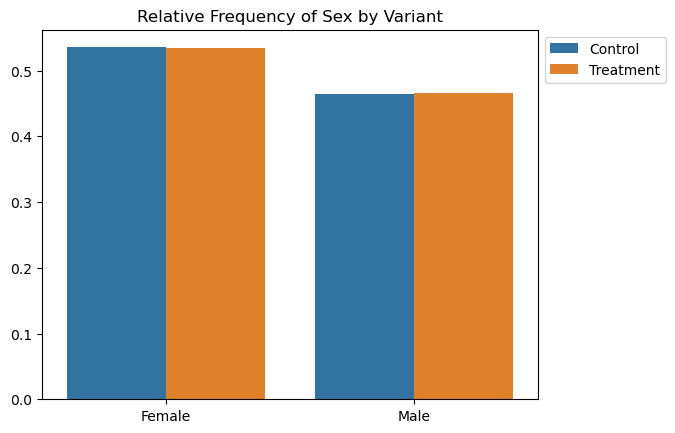

In [141]:
# Distribution of sex by variant

## Create bar plot
variant_rfreq_sex = sns.barplot(data = groupby_variants['sex'].value_counts(normalize = True).reset_index(),
            x = 'sex',
            y = 'proportion',
            hue = 'variant'
           )

## Format bar plot
variant_rfreq_sex.set_title('Relative Frequency of Sex by Variant')
variant_rfreq_sex.set_xlabel('')
variant_rfreq_sex.set_ylabel('')

variant_rfreq_sex.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

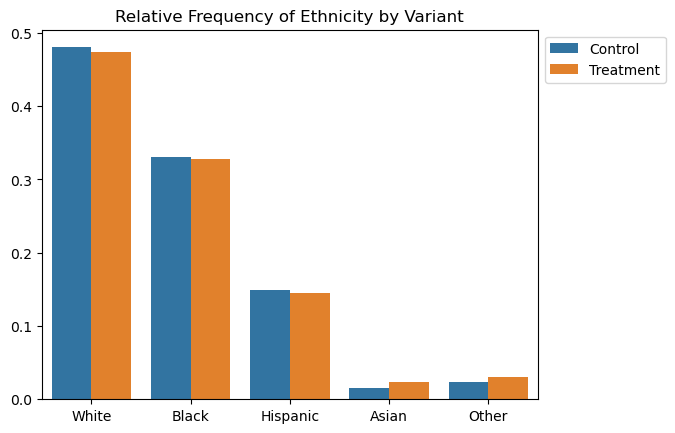

In [142]:
# Distribution of ethnicity by variant

## Create bar plot
variant_rfreq_ethnicity = sns.barplot(data = groupby_variants['ethnicity'].value_counts(normalize = True).reset_index(),
            x = 'ethnicity',
            y = 'proportion',
            order = ethnicities,
            hue = 'variant'
           )

## Format bar plot
variant_rfreq_ethnicity.set_title('Relative Frequency of Ethnicity by Variant')
variant_rfreq_ethnicity.set_xlabel('')
variant_rfreq_ethnicity.set_ylabel('')

variant_rfreq_ethnicity.legend(loc = 'upper left', bbox_to_anchor = (1, 1));

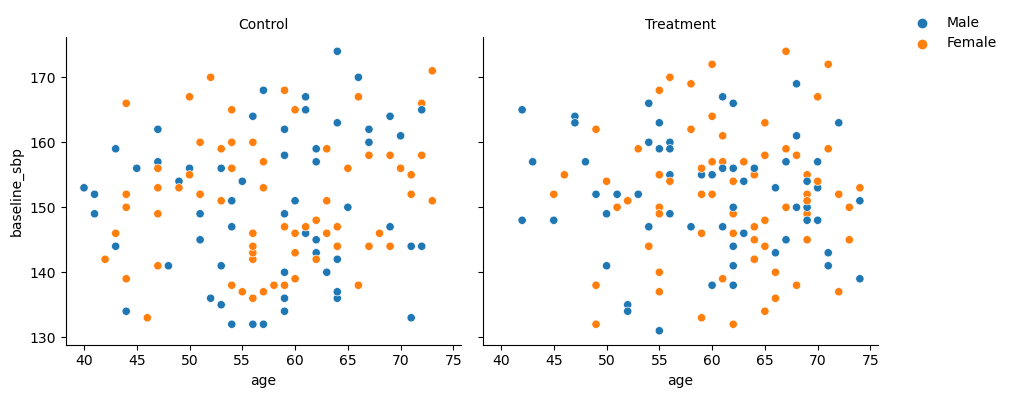

In [143]:
# Create facet grid to split by variant
facet_scatter_1 = sns.FacetGrid(data = df_variants, col = 'variant', height = 4, aspect=1)

# Create scatterplot
facet_scatter_1.map_dataframe(sns.scatterplot, x = 'age', y = 'baseline_sbp', hue = 'sex', hue_order = ['Male', 'Female'])

# Format facet grid
facet_scatter_1.set_titles('{col_name}')
facet_scatter_1.add_legend(loc = 'upper left', bbox_to_anchor = (1, 1))

plt.tight_layout()

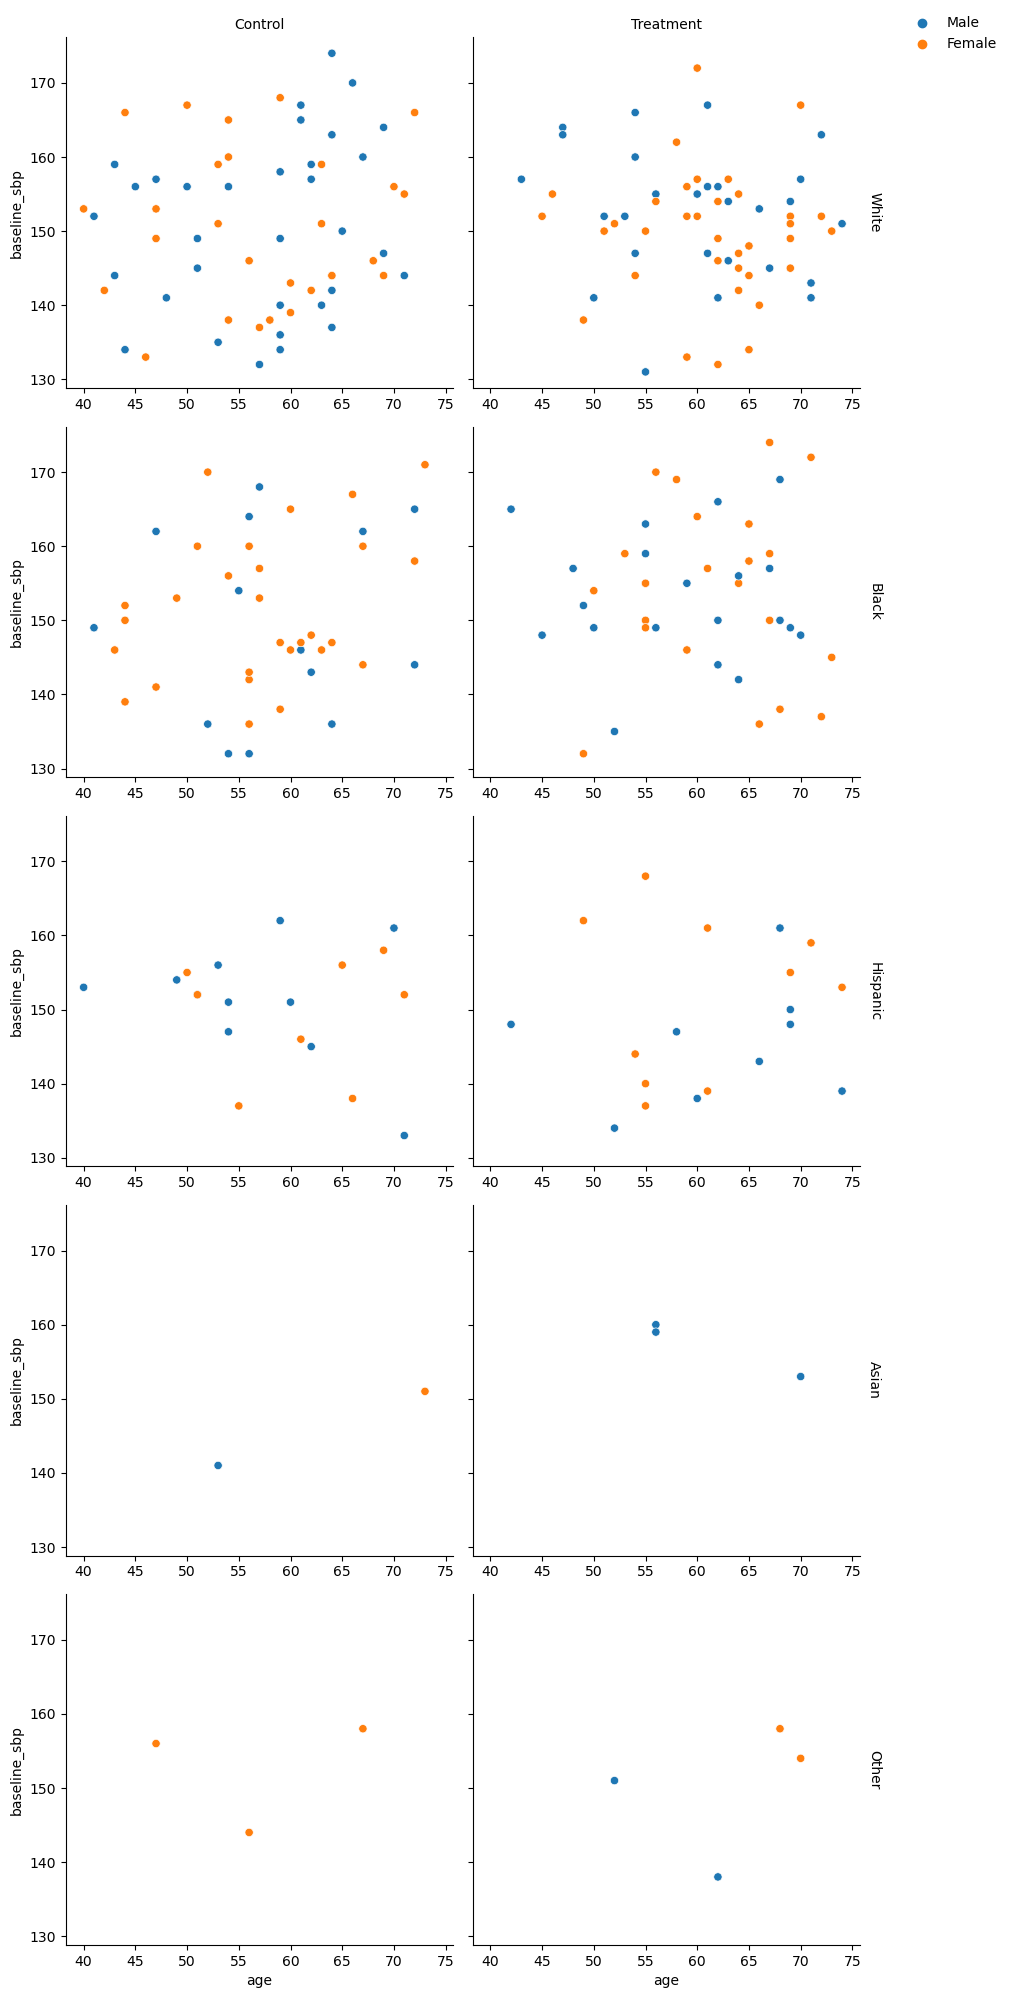

In [144]:
# Create facet grid to split by variant
facet_scatter_2 = sns.FacetGrid(data = df_variants,
                                row = 'ethnicity',
                                row_order = ethnicities,
                                col = 'variant',
                                height = 4,
                                aspect = 1,
                                margin_titles = True
                               )
# Create scatterplot
facet_scatter_2.map_dataframe(sns.scatterplot,
                              x = 'age',
                              y = 'baseline_sbp',
                              hue = 'sex',
                              hue_order = ['Male', 'Female']
                             )

# Format facet grid
facet_scatter_2.set_titles(row_template = '{row_name}', col_template = '{col_name}')
facet_scatter_2.add_legend(loc = 'upper left', bbox_to_anchor = (1, 1))

for ax in facet_scatter_2.axes.flat:
    ax.tick_params(axis = 'x', labelbottom = True)

plt.tight_layout()

In [145]:
age_group_rfreq_variant = groupby_variants['age_group'].value_counts(normalize = True).reset_index().sort_values(by = ['variant', 'age_group'])
age_group_rfreq_variant

,variant,age_group,proportion
2,Control,40s,0.188976
0,Control,50s,0.377953
1,Control,60s,0.338583
3,Control,70s,0.094488
7,Treatment,40s,0.099237
5,Treatment,50s,0.312977
4,Treatment,60s,0.458015
6,Treatment,70s,0.129771


C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


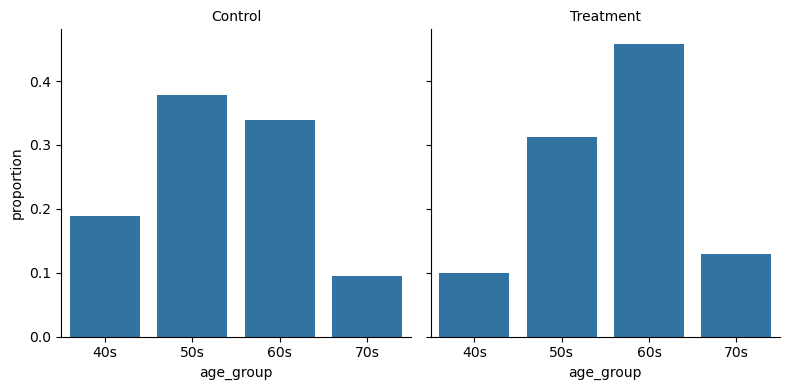

In [146]:
# Create facet grid to split by variant
facet_bar = sns.FacetGrid(data = age_group_rfreq_variant, col = 'variant', height = 4, aspect=1)

# Create bar plot
facet_bar.map_dataframe(sns.barplot, x = 'age_group', y = 'proportion')

# Format facet grid
facet_bar.set_titles('{col_name}')

plt.tight_layout()

C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\eslee\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


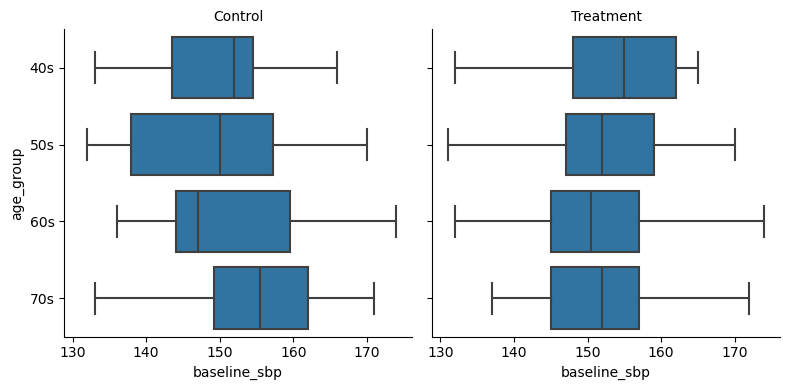

In [147]:
# Create facet grid to split by variant
facet_box_1 = sns.FacetGrid(data = df_variants, col = 'variant', height = 4, aspect=1)

# Create box plot
facet_box_1.map_dataframe(sns.boxplot, x = 'baseline_sbp', y = 'age_group')

# Format facet grid
facet_box_1.set_titles('{col_name}')

plt.tight_layout()

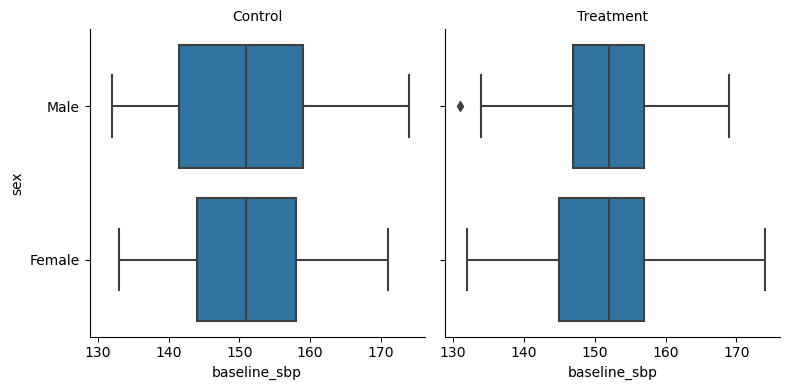

In [148]:
# Create facet grid to split by variant
facet_box_2 = sns.FacetGrid(data = df_variants, col = 'variant', height = 4, aspect=1)

# Create box plot
facet_box_2.map_dataframe(sns.boxplot, x = 'baseline_sbp', y = 'sex', order = ['Male', 'Female'])

# Format facet grid
facet_box_2.set_titles('{col_name}')

plt.tight_layout()

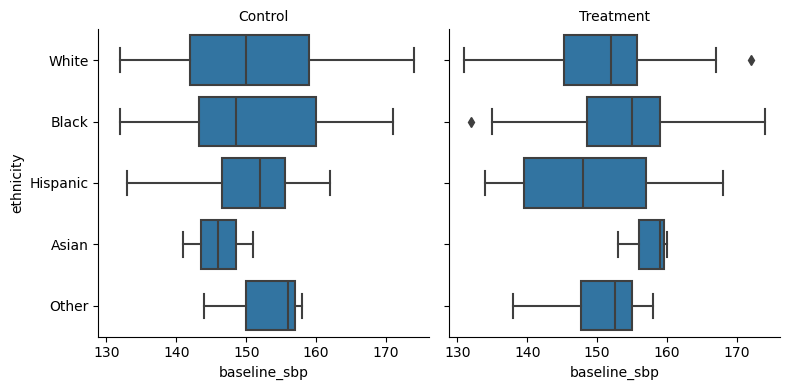

In [149]:
# Create facet grid to split by variant
facet_box_3 = sns.FacetGrid(data = df_variants, col = 'variant', height = 4, aspect=1)

# Create box plot
facet_box_3.map_dataframe(sns.boxplot, x = 'baseline_sbp', y = 'ethnicity', order = ethnicities)

# Format facet grid
facet_box_3.set_titles('{col_name}')

plt.tight_layout()

Notes:

* Sample size was split close to 50/50 between the variants.
* Univariate distributions are similar between the aggregate dataset and the variants, as well as between the variants.
* However, there are some differences in the multivariate distributions of baseline systolic blood pressure and age group/ethnicity between the
  aggregate dataset and the variants, as well as between the variants.
* No notable correlation between age and baseline systolic blood pressure in each variant, even after accounting for differences in sex and ethnicity.
* Sample sizes are too small for ethnicities 'Asian' and 'Other' to draw meaningful statistical inferences.

## Takeaway

Further testing would be required to determine whether the differences in the multivariate distributions are due to random chance or statistically significant. However, given that the sample size is not large enough to warrant a more granular stratified analysis, this A/B test will take advantage of the similarities in the univariate distributions to assess the efficacy of the medication at the general population level.  

# Obtaining the post-experiment data

A synthetic dataset was generated to simulate the results of an 8-weeks clinical trial testing the efficacy of the blood pressure medication.

In [155]:
df_post = pd.read_csv(filepath_or_buffer = 'post_sbp_data.csv')
df_post

,patient_id,age,age_group,sex,ethnicity,baseline_sbp,variant,side_effect,post_sbp
0,P1275,59,50s,Male,White,149,Control,No,153
1,P1272,68,60s,Female,Other,158,Treatment,No,152
2,P1197,69,60s,Female,Hispanic,155,Treatment,No,152
3,P1164,47,40s,Female,White,153,Control,No,157
4,P1095,59,50s,Female,Black,146,Treatment,No,129
...,...,...,...,...,...,...,...,...,...
253,P1267,64,60s,Male,White,137,Control,No,133
254,P1118,69,60s,Female,Hispanic,158,Control,No,158
255,P1221,61,60s,Female,Black,147,Control,No,148
256,P1121,69,60s,Male,White,154,Treatment,No,144


# Conducting the statistical hypothesis test

Recall that the OEC states that the blood pressure medication will not be further developed if 5% or more of the treatment group experiences side effects regardless of what happens to blood pressure. Let's first check what percentage of the treatment group experienced side effects.

In [158]:
# Check percentage of treatment group with side effects
df_post[df_post['variant'] == 'Treatment'].value_counts(subset = 'side_effect', normalize = True)

side_effect
No     0.984733
Yes    0.015267
Name: proportion, dtype: float64

Notes:

* About 1.5% of the treatment group experienced side effects. This allows us to continue with the statistical hypothesis test.

Next, let's compare the distribution of post_sbp between the variants.

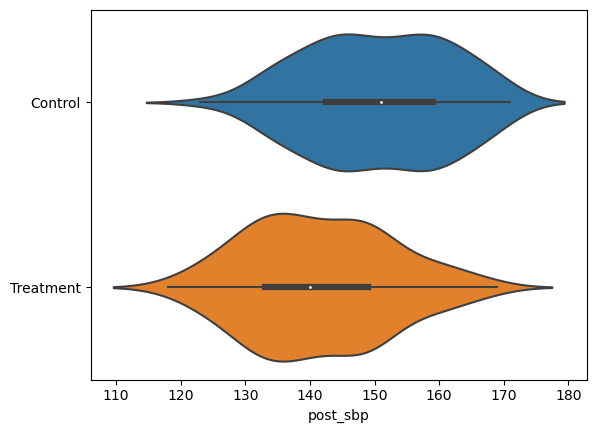

In [161]:
# Compare distribution of post_sbp between variants
post_sbp_variants = sns.violinplot(data = df_post, y = 'variant', x = 'post_sbp')
post_sbp_variants.set_ylabel('');

In [162]:
# Compare the sample mean and standard deviation of post_sbp between the variants
groupby_variants_ss = df_post.groupby(by = 'variant')['post_sbp'].agg(['mean', 'std'])
groupby_variants_ss

,mean,std
variant,,
Control,150.574803,10.989547
Treatment,141.473282,11.186756


In [281]:
# Compute observed treatment effect
treatment_effect = groupby_variants_ss.loc['Control', 'mean'] - groupby_variants_ss.loc['Treatment', 'mean'] 
print(f'Treatment effect: {treatment_effect}')

Treatment effect: 9.101520706858224


Notes:
* The difference in sample mean post_sbp between the control and treatment groups is about 9.1 mmHG.
* Standard deviation of post_sbp is similar at approximately 11 mmHG.

Recall that the treatment effect with practical significance was 5 mmHG. While the treatment effect resulting from the experiment is about 9.1 mmHG, the A/B test must determine whether this is statistically significant. To conduct the statistical hypothesis test, the following statistical properties are invoked:

* The sample size of each variant is large enough to invoke the Central Limit Theorem, which states that the sampling distribution of the sample mean
  post_sbp for each variant will be normally distributed with a mean equal to the true population mean post_sbp and a standard error equal to the sample
  standard deviation of posb_sbp divided by the square root of the sample size.

* The random and independent assignment of the aggregate sample to the variants makes it possible to invoke the Sum of Gaussians, which states that the
  difference in the sampling distribution of the sample mean post_sbp between the variants will be normally distributed with a mean equal to the
  difference in the true population mean post_sbp between the variants and a variance equal to the sum of each variant's variance of the sampling
  distribution of the sample mean post_sbp.

* Since the sample standard deviation of post_sbp is used to estimate the true population standard deviation of post_sbp, a t-distribution with a
  degrees of freedom adjustment is used for statistical hypothesis testing to incorporate fatter tails.

    <span style="font-size:150%;">
    $
    d.o.f = \frac{
        \left( \frac{s_c^2}{n_c} + \frac{s_t^2}{n_t} \right)^2
    }{
        \frac{ \left( \frac{s_c^2}{n_c} \right)^2 }{n_c - 1} + 
        \frac{ \left( \frac{s_t^2}{n_t} \right)^2 }{n_t - 1}
    }
    $
    </span>

In [283]:
# Sample standard deviations of variants
std_control = groupby_variants_ss.loc['Control', 'std']   
std_treatment = groupby_variants_ss.loc['Treatment', 'std']

# Sample sizes of variants
n_control = variant_freq.loc[0, 'count']
n_treatment = variant_freq.loc[1, 'count']

# Standard error of variants
se_control = np.sqrt((std_control ** 2) / n_control)
se_treatment = np.sqrt((std_treatment ** 2) / n_treatment)

# Print results
print(f'Sample stdev (control): {std_control}')
print(f'Sample stdev (treatment): {std_treatment}')
print(f'Sample size (control): {n_control}')
print(f'Sample size (treatment): {n_treatment}')
print(f'Standard error (control): {se_control}')
print(f'Standard error (control): {se_treatment}')

Sample stdev (control): 10.989547476160412
Sample stdev (treatment): 11.186756073606933
Sample size (control): 127
Sample size (treatment): 131
Standard error (control): 0.9751646488508366
Standard error (control): 0.9773914162387882


In [285]:
# Variance of the Sum of Gaussians
var_sum_gauss = (se_control ** 2) + (se_treatment ** 2)

# Standard error of the Sum of Gaussians
se_sum_gauss = np.sqrt(var_sum_gauss)

# Print
print(f'Standard error (Sum of Gaussians): {se_sum_gauss}')

Standard error (Sum of Gaussians): 1.3806665321161513


In [169]:
# Function to compute degrees of freedom
def welch_degrees_of_freedom(s_c, n_c, s_t, n_t):
    """
    Calculate degrees of freedom for Welch's t-test.

    Parameters:
        s_c (float): Sample standard deviation of control group
        n_c (int): Sample size of control group
        s_t (float): Sample standard deviation of treatment group
        n_t (int): Sample size of treatment group

    Returns:
        float: Welch-Satterthwaite degrees of freedom
    """
    # Variances
    var_c = s_c**2
    var_t = s_t**2

    # Numerator
    numerator = (var_c / n_c + var_t / n_t) ** 2

    # Denominator
    denominator = ((var_c / n_c) ** 2) / (n_c - 1) + ((var_t / n_t) ** 2) / (n_t - 1)

    # Degrees of freedom
    dof = numerator / denominator

    return dof

In [287]:
# Compute degrees of freedom
dof = welch_degrees_of_freedom(std_control, n_control, std_treatment, n_treatment)

# Print
print(f'Degree of freedom: {dof}')

Degree of freedom: 255.95441215010052


$H_0$: $\mu_c$ - $\mu_t$ $\leq 0$

$H_A$: $\mu_c$ - $\mu_t$ $> 0$

In [291]:
# Probability of observing treatment effect ~ 9.1 mmHG 
# given null hypothesis that true treatment effect = 0
p_value = st.t.sf(x = treatment_effect, df = dof, loc = 0, scale = se_sum_gauss)

# Print
print(f'P(Treatment Effect ~ 9.1 mmHG | Null = True): {p_value}')

P(Treatment Effect ~ 9.1 mmHG | Null = True): 1.2311115678295873e-10


# Conclusion

## Statistical significance

The probability of observing a ~9.1 mmHG reduction in systolic blood pressure when the medication is actually ineffective is close to 0%. This result is statistically significant.

## Practical significance

The observed ~9.1 mmHG reduction in systolic blood pressure resulting from the medication exceeds the treatment effect with practical significance, which was set at a 5 mmHG reduction in systolic blood pressure. The combination of statistical significance and practical significance provides strong support for continuing to develop the medication.

## Possible next steps

Conduct a more extensive clinicial trial with a larger sample size to identify potential confounding variables (e.g., age group and/or ethnicity) and to assess the efficacy of the medication across different demographics.